<a href="https://colab.research.google.com/github/Divya-Swaroopini/ML_team_buzz/blob/main/ProjectPDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Drive + Unzipping the files into a new folder
from google.colab import drive
drive.mount('/content/gdrive')

!unzip gdrive/MyDrive/PlantDiseaseDataset/Apple.zip


Streaming output truncated to the last 5000 lines.
  inflating: Apple/Apple___healthy/526782c6-8d24-4438-8255-37422811d33f___RS_HL 7601_90degFlipLR.JPG  
  inflating: Apple/Apple___healthy/526782c6-8d24-4438-8255-37422811d33f___RS_HL 7601_90degFlipTB.JPG  
  inflating: Apple/Apple___healthy/52cf2701-f319-4b3e-b6fb-8071f2f09ca9___RS_HL 8191.JPG  
  inflating: Apple/Apple___healthy/52cf2701-f319-4b3e-b6fb-8071f2f09ca9___RS_HL 8191_FlipTB.JPG  
  inflating: Apple/Apple___healthy/5348c7f1-02d4-40ae-989e-1537043644cf___RS_HL 7657.JPG  
  inflating: Apple/Apple___healthy/5356ef92-e60f-4456-8687-f8b624d60b53___RS_HL 5829_90degFlipLR.JPG  
  inflating: Apple/Apple___healthy/53ad897b-864f-414f-84e7-0ea0ce53fa1d___RS_HL 7273.JPG  
  inflating: Apple/Apple___healthy/53ad897b-864f-414f-84e7-0ea0ce53fa1d___RS_HL 7273_90degFlipLR.JPG  
  inflating: Apple/Apple___healthy/53b0c397-52b3-40c1-9ef5-c52b6ae7f4bb___RS_HL 6329_90degFlipLR.JPG  
  inflating: Apple/Apple___healthy/53d09cc6-89ef-4180-a823-31c5

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch import utils
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)
torch.cuda.empty_cache()

Running on cuda


In [4]:
#Update name of dataset

path = '/content/Apple'
cls = os.listdir(path)
class_map = {}
for cl in cls:
  n = len(os.listdir(path + '/' + cl))
  class_map[cl] = n
print(class_map)


{'Apple___Apple_scab': 2017, 'Apple___Cedar_apple_rust': 880, 'Apple___Black_rot': 1988, 'Apple___healthy': 5264}


In [5]:
#Transform to Tensor
transform =  transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor()])
#Doubt : Why Exactly do they usually resize the Input to 224x224?
#Note : Look up the concept of normalization again to fully understand why this is done
data_ = datasets.ImageFolder(path, transform=transform)

#Split into 3 subsets -> 30 | 35 | 35
size1 = int(len(data_) * 0.3)
size2 = int((len(data_) - size1) / 2)
size3 = int(len(data_) - (size1 + size2))
data1, data2, data3 = utils.data.random_split(data_, [size1, size2, size3])

In [6]:
def process_and_split__data(data):

  testSize = int(len(data) * 0.3)
  trainSize = len(data) - testSize
  train_set, test_set = utils.data.random_split(data, [trainSize, testSize])

  #Use Dataloader to load the data into an itterable form (Set 1)
  train = utils.data.DataLoader(train_set, batch_size = 32, shuffle = True)
  test = utils.data.DataLoader(test_set, batch_size = 32, shuffle = True)
  
  return train, test

In [7]:
#Comparing DataDistribution between the two classes
def compareDataSegments(data1, data2, data3):
  data1loader = utils.data.DataLoader(data1, batch_size = 32, shuffle = True)
  data2loader = utils.data.DataLoader(data2, batch_size = 32, shuffle = True)
  data3loader = utils.data.DataLoader(data2, batch_size = 32, shuffle = True)
  
  #Class Names of Numeric Labels
  classes = os.listdir(path)
  classes.sort()
  class_to_idx = {classes[i]: i for i in range(len(classes))}
  print(class_to_idx)

  class_count_data1 = DataCount(data1loader)
  class_count_data2 = DataCount(data2loader)
  class_count_data3 = DataCount(data3loader)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_title('Data Distribution between segments of the Dataset', loc='left')

  # Set position of bar on X axis
  br1 = np.arange(len(class_count_data1))
  br2 = [x + 0.25 for x in br1]
  br3 = [x + 0.25 for x in br2]

  ax.bar(br1, class_count_data1, color = 'blue', width = 0.25, edgecolor ='black')
  ax.bar(br2, class_count_data2, color = 'grey', width = 0.25, edgecolor ='black')
  ax.bar(br3, class_count_data3, color = 'pink', width = 0.25, edgecolor ='black')


  plt.xlabel('Data Segments', fontweight='bold')
  plt.ylabel('Class Count', fontweight='bold')
  plt.xticks([r + 0.25 for r in range(len(class_count_data1))], [str(c) for c in range(len(class_count_data1))])
    
  plt.show()

In [8]:
#Update class_count to the number of classes here

#calculating the class distribution over a dataset
def DataCount(dataloader):
  class_count = np.zeros((4,), dtype=int)
  for i, batch in enumerate(dataloader):
      image, classes = batch
      labels = np.array(classes)
      for label in labels:
        for i in range(len(classes)):
          if(label == i):
            class_count[i] = class_count[i] + 1
  print(class_count)
  return class_count

In [9]:
#Plotting the claculated class distributions
def plot_class_distributions(class_count_train, class_count_test):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_title('Data Distribution', loc='left')

  # Set position of bar on X axis
  br1 = np.arange(len(class_count_train))
  br2 = [x + 0.25 for x in br1]
  br3 = [x + 0.25 for x in br2]

  ax.bar(br1, class_count_train, color = 'grey', width = 0.25, edgecolor ='black', label = 'Train')
  ax.bar(br2, class_count_test, color = 'pink', width = 0.25, edgecolor ='black', label = 'Test')

  plt.xlabel('DataSets', fontweight='bold')
  plt.ylabel('Class Count', fontweight='bold')
  plt.xticks([r + 0.25 for r in range(len(class_count_train))], [str(c) for c in range(len(class_count_train))])
   
  plt.show()

  #Class Names of Numeric Labels
  classNames = os.listdir(path)
  classNames.sort()
  class_to_idx = {classNames[i]: i for i in range(len(classNames))}
  print(class_to_idx)

In [10]:
#CURRENTLY NOT IN USE
#Class Ratios : Are they as even as expected?
def check_class_ratio(class_count_train, class_count_test, classes):
  class_ratios = np.zeros(())
  #Initialize an empty zeroes array for all 39 classes

  for i in range(len(classes)):
    aggregate = class_count_train[i] + class_count_test[i]
    #print(aggregate)
    class_ratios[i][0] = round((class_count_train[i] / aggregate) * 100, 2)
    class_ratios[i][1] = round((class_count_test[i] / aggregate) * 100, 2)

  print("Rough Percentage of Class Division amongst the three train and test sets")
  for i in range(len(classes)):
    print(class_ratios[i])
    print()

In [11]:
#Creating a simple CNN architechture
class SimpleCustomCNN(nn.Module):
  def __init__(self):
    super(SimpleCustomCNN, self).__init__()

    #Defining a sequential model layers
    self.c1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=5, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    self.drop = nn.Dropout()
    self.fc1 = nn.Linear(in_features = 54*54*32, out_features = 4)

  def forward(self, x):
    output = self.c1(x)
    output = self.c2(output)
    output = output.reshape(output.size(0), -1)
    #or nn.Flatten()
    #To prevent over fitting
    output = self.drop(output)
    output = self.fc1(output)
    return output

In [12]:
#Calling all the functions to visualize the Data
def datasets_visualization(train, test):

  dataiter = iter(train)
  images, classes = dataiter.next()

  print(type(images))
  print(images.shape)
  print(classes.shape)

  class_count_train = DataCount(train)
  class_count_test = DataCount(test)

  #Check if the Ratio of the Train:Val:Test has been maintained through the classes:
  #check_class_ratio(class_count_train, class_count_test, classes)

  #Plot to Visualize the way Data is Distributed between the sets
  plot_class_distributions(class_count_train, class_count_test)


In [13]:
def train_test_model(e, train, test, model, optimizer):

  train_losses = []
  train_accuracy_list = []

  test_losses = []
  test_accuracy_list = []


  for epoch in range(e):

    run_loss = 0.0
    val_loss = 0.0

    #TRAINING

    model.train()
    correct = 0
    total = 0

    for img, class_ in train:
      
          img, class_ = img.to(device), class_.to(device)
  
          #flood = (loss-b).abs()+b

          optimizer.zero_grad()
          preds = model(img)

          loss = lossCriteria(preds, class_)

          loss.backward()
          optimizer.step()

          run_loss += loss.item()

          _, predicted = preds.max(1)
          total += class_.size(0)
          correct += predicted.eq(class_).sum().item()

    
    accuracy_train = correct * 100. / total
    train_accuracy_list.append(accuracy_train)


    train_loss = run_loss / len(train.sampler)
    train_losses.append(train_loss)

    #TESTING
    with torch.no_grad():
      model.eval()
      correct_ = 0
      total_ = 0
      
      for img, class_ in test:

          img, class_ = img.to(device), class_.to(device)

          preds_ = model(img)
          loss = lossCriteria(preds_, class_)
          val_loss += loss.item()
            
          _, predicted = preds_.max(1)
          total_ += class_.size(0)
          correct_ += predicted.eq(class_).sum().item()
    
    accuracy_test = correct_ * 100. / total_
    test_accuracy_list.append(accuracy_test)


    test_loss = val_loss / len(test.sampler)
    test_losses.append(test_loss)


    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(epoch, train_loss, accuracy_train, test_loss, accuracy_test))

  return train_losses, train_accuracy_list, test_losses, test_accuracy_list


In [19]:
#Visulaize the Results
def plot_acc_curve(train_accuracy, test_accuracy):
  plt.plot(train_accuracy, color='green')
  plt.plot(test_accuracy, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Testing Accuracy')
 
  plt.show()

def plot_loss_curve(train_losses, test_losses):
  plt.plot(train_losses, color='green')
  plt.plot(test_losses, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('Training and Testing Losses')
 
  plt.show()

In [15]:
#Call the Train and Validate and Test Functions
def train_test_models(model_, train, test, optimizer_):
  train_losses, train_accuracy, test_losses, test_accuracy = train_test_model(100, train, test, model_, optimizer_)

  plot_loss_curve(train_losses, test_losses)
  plot_acc_curve(train_accuracy, test_accuracy)


In [16]:
#Splitting into training and testing datasets
train1, test1 = process_and_split__data(data1)
train2, test2 = process_and_split__data(data2)
train3, test3 = process_and_split__data(data3)

SimpleCustomCNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=93312, out_features=4, bias=True)
)
Epoch: 0 	Training Loss: 0.0380 	Training Accuracy: 50.5397 	Test Loss: 0.0374 	Test Accuracy: 52.3549
Epoch: 1 	Training Loss: 0.0373 	Training Accuracy: 50.6804 	Test Loss: 0.0368 	Test Accuracy: 52.3549
Epoch: 2 	Training Loss: 0.0365 	Training Accuracy: 50.6804 	Test Loss: 0.0359 	Test Accuracy: 52.3549
Epoch: 3 	Training Loss: 0.0356 	Training Accuracy: 50.8212 	Test Loss: 0.0353 	Test Accuracy: 52.3549
Epoch: 4 	Training Loss: 0.0347 	Training Accuracy: 51.3374 	Test Loss: 0.0339 	Tes

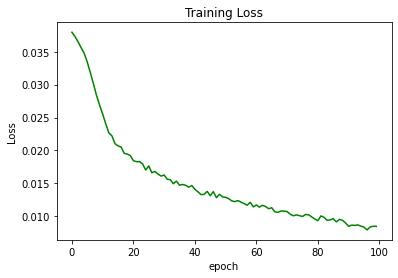

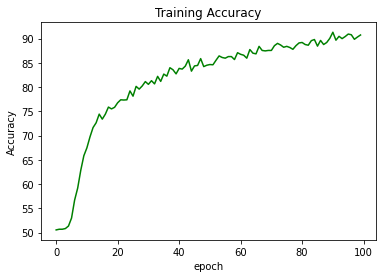

In [17]:
#Cross Entropy Function
lossCriteria = nn.CrossEntropyLoss()

#Initialize model and optimizer 1
#Note : 0.01 is actually the default value of the weight decay
model1 = SimpleCustomCNN().to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.001, weight_decay = 0.01)
print(model1)
#Calling the training function for model 1
train_test_models(model1, train1, test1, optimizer1)


In [18]:
#Initialize model and optimizer 2
model2 = SimpleCustomCNN().to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001, weight_decay = 0.01)
print(model2)
#Calling the training function for model 2
train_test_models(model2, train2, test2, optimizer2)


SimpleCustomCNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=93312, out_features=4, bias=True)
)
Epoch: 0 	Training Loss: 0.0374 	Training Accuracy: 51.8295 	Test Loss: 0.0378 	Test Accuracy: 52.3944
Epoch: 1 	Training Loss: 0.0362 	Training Accuracy: 52.2718 	Test Loss: 0.0365 	Test Accuracy: 53.0516
Epoch: 2 	Training Loss: 0.0352 	Training Accuracy: 52.5131 	Test Loss: 0.0345 	Test Accuracy: 52.5822
Epoch: 3 	Training Loss: 0.0334 	Training Accuracy: 53.4379 	Test Loss: 0.0330 	Test Accuracy: 54.5540
Epoch: 4 	Training Loss: 0.0318 	Training Accuracy: 55.6896 	Test Loss: 0.0310 	Tes

KeyboardInterrupt: ignored

In [ ]:
#Initialize model and optimizer 3
model3 = SimpleCustomCNN().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay = 0.01)
print(model3)
#Calling the training function for model 3
train_test_models(model3, train3, test3, optimizer3)

In [ ]:
def visualizations():

  #Visualizing the Induvidual Datasets :
  print("Dataset Segment 1 : ")
  datasets_visualization(train1, test1)
  print("Dataset Segment 2 : ")
  datasets_visualization(train2, test2)
  print("Dataset Segment 3 : ")
  datasets_visualization(train3, test3)

  #Compare these Data Segemnts
  compareDataSegments(data1, data2, data3)

visualizations()

In [ ]:
'''
#Visualize through a confusion matrix

#Getting the list of prediction made by model
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

#Counting the total number of correct predictions made
def get_num_correct():

#Calling above two functions
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train1, batch_size=10000)
    train1_preds = get_all_preds(network, prediction_loader)
preds_correct = get_num_correct(train1_preds, train1.targets)

print('Total Correct:', preds_correct)
print('Accuracy:', preds_correct / len(train1))'''

In [ ]:
#saving model state:
#torch.save(model.state_dict(), '/content/gdrive/MyDrive/CustomCNN_93.4911_apple')

In [ ]:
#Load Previously saved model
'''
modelOld =  SimpleCustomCNN().to(device)
modelOld.load_state_dict = torch.load('/content/gdrive/MyDrive/CustomCNN_93.4911_apple')
print(modelOld)
modelOld.to(device)
'''